In [5]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import scipy.io as sio
from sklearn.metrics import accuracy_score, mean_squared_error
from joblib import dump, load
from tensorflow.keras.models import load_model

In [6]:
# Load the dataset
mat = sio.loadmat('/home/utkarsh/Documents/iitb/gnr602/project/dataset/Indian Pines/Indian_pines.mat')
mat_gt = sio.loadmat('/home/utkarsh/Documents/iitb/gnr602/project/dataset/Indian Pines/Indian_pines_gt.mat')

data = mat['indian_pines']
labels = mat_gt['indian_pines_gt']

In [8]:
import numpy as np

class StandardScaler:
    def __init__(self):
        self.mean_ = None
        self.scale_ = None

    def fit(self, X):
        self.mean_ = np.mean(X, axis=0)
        self.scale_ = np.std(X, axis=0)

    def transform(self, X):
        return (X - self.mean_) / self.scale_

    def fit_transform(self, X):
        self.fit(X)
        return self.transform(X)

In [7]:
import numpy as np

def lda(X, y, num_components):
    # compute class means
    means = []
    for c in np.unique(y):
        means.append(np.mean(X[y == c], axis=0))
    
    # compute within-class scatter matrix
    Sw = np.zeros((X.shape[1], X.shape[1]))
    for c, mean in zip(np.unique(y), means):
        class_sc_mat = np.zeros((X.shape[1], X.shape[1]))  
        for row in X[y == c]:
            row, mean = row.reshape(X.shape[1],1), mean.reshape(X.shape[1],1) 
            class_sc_mat += (row-mean).dot((row-mean).T)
        Sw += class_sc_mat  
    
    # compute between-class scatter matrix
    Sb = np.zeros((X.shape[1], X.shape[1]))
    grand_mean = np.mean(X, axis=0).reshape(X.shape[1],1)
    for c, mean in zip(np.unique(y), means):
        n = X[y==c,:].shape[0]
        mean = mean.reshape(X.shape[1],1)
        Sb += n * (mean - grand_mean).dot((mean - grand_mean).T)
    
    # compute eigenvalues and eigenvectors of Sw^-1*Sb
    eigen_vals, eigen_vecs = np.linalg.eig(np.linalg.inv(Sw).dot(Sb))
    eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:,i]) for i in range(len(eigen_vals))]
    eigen_pairs = sorted(eigen_pairs, key=lambda k: k[0], reverse=True)
    
    # extract the top k eigenvectors as LDA components
    lda_components = np.zeros((X.shape[1], num_components))
    for i in range(num_components):
        lda_components[:, i] = eigen_pairs[i][1]
    
    # project data onto the LDA components
    X_lda = X.dot(lda_components)
    
    return X_lda

In [9]:
# Reshape the data to (num_samples, num_features)
n, m, num_samples = data.shape
data_reshaped = np.reshape(data, (n*m, num_samples))
labels_reshaped = np.reshape(labels, (n*m,))

# Apply LDA to reduce the dimensionality of the data
num_components = 16
data_scaled = StandardScaler().fit_transform(data_reshaped)
data_lda = lda(data_scaled, labels.ravel(), num_components)

# dump(pipeline, 'lda_pipeline.joblib')

from keras.models import Sequential
from keras.layers import Dense, Conv1D

# Define the neural network architecture
model = Sequential()
model.add(Dense(64, activation='relu', input_dim=data_lda.shape[1]))
model.add(Dense(32, activation='relu'))
model.add(Dense(17, activation='softmax'))

model.summary()

# Compile the model with categorical cross-entropy loss and Adam optimizer
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Convert labels to one-hot encoding
num_labels = len(np.unique(labels_reshaped))
labels_onehot = np.eye(num_labels)[labels_reshaped.reshape(-1)]

# print(labels_onehot)

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(data_lda, labels_onehot, test_size=0.3, random_state=42)

# Train the neural network on the training set
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)

# Evaluate the neural network on the test set
loss, accuracy = model.evaluate(X_test, y_test)
print("Test accuracy:", accuracy)

model.save('../models/lda_model.h5')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                1088      
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 17)                561       
                                                                 
Total params: 3,729
Trainable params: 3,729
Non-trainable params: 0
_________________________________________________________________


/tmp/ipykernel_47174/2759968207.py:34: ComplexWarning: Casting complex values to real discards the imaginary part
  lda_components[:, i] = eigen_pairs[i][1]


Epoch 1/50
368/368 [==============================] - 1s 2ms/step - loss: 1.5017 - accuracy: 0.5808 - val_loss: 1.0378 - val_accuracy: 0.6406
Epoch 2/50
368/368 [==============================] - 1s 2ms/step - loss: 0.8883 - accuracy: 0.6899 - val_loss: 0.8310 - val_accuracy: 0.7116
Epoch 3/50
368/368 [==============================] - 1s 1ms/step - loss: 0.7756 - accuracy: 0.7267 - val_loss: 0.7543 - val_accuracy: 0.7269
Epoch 4/50
368/368 [==============================] - 0s 1ms/step - loss: 0.7262 - accuracy: 0.7355 - val_loss: 0.7106 - val_accuracy: 0.7395
Epoch 5/50
368/368 [==============================] - 1s 1ms/step - loss: 0.6951 - accuracy: 0.7437 - val_loss: 0.6839 - val_accuracy: 0.7388
Epoch 6/50
368/368 [==============================] - 1s 1ms/step - loss: 0.6730 - accuracy: 0.7499 - val_loss: 0.6653 - val_accuracy: 0.7480
Epoch 7/50
368/368 [==============================] - 1s 1ms/step - loss: 0.6581 - accuracy: 0.7550 - val_loss: 0.6450 - val_accuracy: 0.7510
Epoch 

658/658 [==============================] - 1s 861us/step
Clustered labels accuracy: 0.791629013079667
MSE: 20.784019024970274


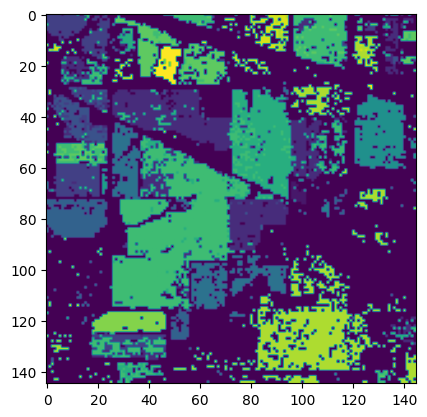

In [14]:
# Reshape the cluster labels and display the segmented image
cluster_labels_onehot = model.predict(data_lda)
# smoothed_preds = np.apply_along_axis(lambda x: np.convolve(x, [1/3, 1/3, 1/3], mode='same'), axis=1, arr=cluster_labels_onehot)
cluster_labels = np.argmax(cluster_labels_onehot, axis=1)

cluster_labels_reshaped = np.reshape(cluster_labels, (n, m))
accuracy = np.mean(cluster_labels_reshaped == labels)
print("Clustered labels accuracy:", accuracy)

cluster_labels_flat = np.reshape(cluster_labels_reshaped, (n*m,))
mse = mean_squared_error(labels_reshaped, cluster_labels_flat)
print("MSE:", mse)
plt.imshow(cluster_labels_reshaped)
plt.savefig('../output/lda_nn_without_gauss.png')
plt.show()

658/658 [==============================] - 1s 771us/step


100%|██████████| 299/299 [00:00<00:00, 631.35it/s]


Best sigma=1.2 with accuracy=0.8514
MSE: 19.039048751486327


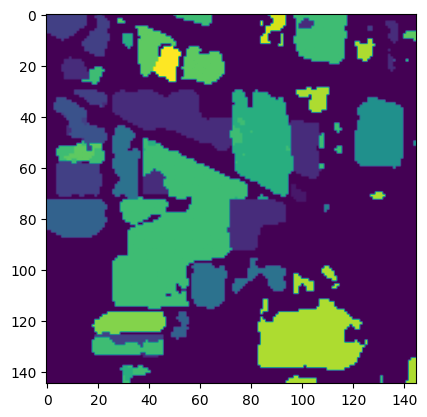

In [16]:
import cv2
from sklearn.metrics import mean_squared_error
from tqdm import tqdm

sigmas = np.arange(0.01, 3.00, 0.01)  # different values of sigma to try
best_accuracy = 0
best_sigma = 0

# Reshape the cluster labels and display the segmented image
cluster_labels_onehot = model.predict(data_lda)
preds = np.reshape(cluster_labels_onehot, (n, m, 17))

for sigma in tqdm(sigmas):
    smoothed_preds = cv2.GaussianBlur(preds, (0, 0), sigma)

    cluster_labels_reshaped = np.argmax(smoothed_preds, axis=2)
    accuracy = np.mean(cluster_labels_reshaped == labels)

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_sigma = sigma
        best_image = cluster_labels_reshaped

print(f"Best sigma={best_sigma:.1f} with accuracy={best_accuracy:.4f}")

cluster_labels_flat = np.reshape(cluster_labels_reshaped, (n*m,))
mse = mean_squared_error(labels_reshaped, cluster_labels_flat)
print("MSE:", mse)
plt.imshow(best_image)
plt.savefig('../output/lda_nn_with_gauss.png')
plt.show()

658/658 [==============================] - 1s 762us/step


100%|██████████| 299/299 [00:00<00:00, 465.45it/s]


Best sigma=1.1 with accuracy=0.8868
MSE: 27.738168846611178


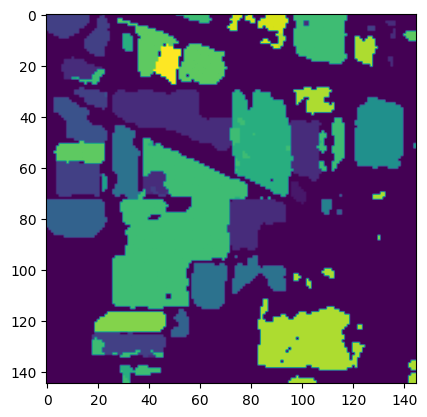

In [43]:
pipeline = load('lda_pipeline.joblib')    
data_lda = pipeline.predict(data_reshaped)

# Create a new array with shape (n, n, 17)
stacked_array = np.zeros((data_lda.shape[0], 16))

# Stack the image 17 times along the last axis
for i in range(16):
    stacked_array[:, i] = data_lda

data_lda = stacked_array

model = load_model('lda_model.h5')
cluster_labels_onehot = model.predict(data_lda)

preds = np.reshape(cluster_labels_onehot, (n, m, 17))

for sigma in tqdm(sigmas):
    smoothed_preds = cv2.GaussianBlur(preds, (0, 0), sigma)

    cluster_labels_reshaped = np.argmax(smoothed_preds, axis=2)
    accuracy = np.mean(cluster_labels_reshaped == labels)

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_sigma = sigma
        best_image = cluster_labels_reshaped

print(f"Best sigma={best_sigma:.1f} with accuracy={best_accuracy:.4f}")

cluster_labels_flat = np.reshape(cluster_labels_reshaped, (n*m,))
mse = mean_squared_error(labels_reshaped, cluster_labels_flat)
print("MSE:", mse)
plt.imshow(best_image)
plt.show()
